Refer to the [Wikipedia article](https://en.wikipedia.org/wiki/Self-avoiding_walk) on self-avoiding walks for a good primer on the subject. [Bauerschmidt et al. (2012)](https://www.ihes.fr/~duminil/publi/saw_lecture_notes.pdf) give an extremely thorough description of known qualities of self-avoiding random walks and their connections to other areas of mathematics. Here are links to some other resources I found informative:
 - https://mathoverflow.net/questions/158811/wander-distance-of-self-avoiding-walk-that-backs-out-of-culs-de-sac
 - https://mathoverflow.net/questions/52813/self-avoiding-walk-enumerations
 - https://mathoverflow.net/questions/41543/how-to-characterize-a-self-avoiding-
 - https://mathoverflow.net/questions/54144/self-avoiding-walk-pair-correlation
 - https://mathoverflow.net/questions/23583/self-avoidance-time-of-random-walk
 - https://mathoverflow.net/questions/181340/square-filling-self-avoiding-walk
 
Some exhaustive results by numerical simulation are available here:
 - https://secure.math.ubc.ca/~slade/lacecounts/index.html
 - https://secure.math.ubc.ca/~slade/se_tables.pdf
 
Here are some other academic results on the topic:
 - https://secure.math.ubc.ca/~slade/se_tables.pdf
 - https://www.sciencedirect.com/science/article/abs/pii/0032386185900084?via%3Dihub
 - https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.2993
 - https://arxiv.org/abs/1408.6714
 
Other interesting simulations/related information:
 - https://mathoverflow.net/questions/88659/traversing-the-infinite-square-grid
 - https://mathoverflow.net/questions/306794/counting-hamiltonian-cycles-in-n-times-n-square-grid
 - https://iopscience.iop.org/article/10.1088/0305-4470/38/42/001
 - https://mathoverflow.net/questions/67192/exactly-simulating-a-random-walk-from-infinity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import itertools
import random

In [2]:
dimensions = 2
D = dimensions
z = 10

start = [0, 0]
choices = []

for n in range(dimensions):
    for y in [-1, 1]:
        delta = np.zeros(dimensions).astype(np.int)
        delta[n] = y
        choices.append(delta)
choices = np.stack(choices)

print(choices)

[[-1  0]
 [ 1  0]
 [ 0 -1]
 [ 0  1]]


In [3]:
steps = []
@nb.njit
def valid_moves(g, m, q):
#     filtered = list(filter(lambda c: (0<=pos+c).all() and (pos+c<z).all() and grid[tuple(pos+c)] == 0, m))
    filtered = []
    for i in m:
#         print(pos, m)
        p = q+i
#         if (0<=p).all() and (p<z).all() and g[p[0], p[1]] == 0:
        if (0<=p).all():
            if (p<z).all():
                if g[p[0], p[1]] == 0:
#                     print(p, g[p[0], p[1]], (p<z).all(), z)
                    filtered.append(i)
    return filtered

In [4]:
@nb.jit(nopython=True)
def bound(x, a, b):
    if x >= b:
        x = b-1
    elif x < a:
        x = a
    return x

@nb.njit
def clip(x, a, b):
    for i in range(x.shape[0]):
        x[i] = bound(x[i], a, b)
    return x

In [203]:
@nb.njit#(parallel=True)
def simulate(z, m=1, backtrack=True):
    for x in range(1):
        pos = np.array([0, 0])
#         grid = np.zeros([z] * D)
        grid = np.zeros((z, z), dtype=np.int64)
#         walks = []
#         steps = []
#         steps.append(pos)

#         steps = np.zeros((z**2, 2))
#         steps[0] = pos
        l = 1
        
        for t in range(z**2*m):
    #         print(0<pos+delta[0]<z)
    #         print(grid[tuple(pos+delta[0])])
            possible = valid_moves(grid, choices, pos)
#             print(possible)
            grid[pos[0], pos[1]] = l+(z**2//4)
            
            if len(possible) > 0:
#                 delta = random.choice(possible)
#                 delta = np.random.choice(possible)
#                 np.random.shuffle(possible)
                index = np.random.randint(0, len(possible))
                delta = possible[index]

#                 steps.append(delta)
                pos += delta
#                 steps.append(delta)
#                 steps[l] = delta

#                 pos = np.clip(pos, 0, z-1)
                
                pos = clip(pos, 0, z)
                
#                 grid[tuple(pos)] = 1
#                 print(pos[0])

                if np.count_nonzero(grid) <= z**2-1:
                    l += 1
            else:
#                 lengths.append(t)
#                 walks.append(grid)
                if backtrack:
                    # TODO: prevent reselection of "stuck" path
            
                    grid[pos[0], pos[1]] = 0
                    pos -= delta
                    pos = clip(pos, 0, z)
#                     steps.pop()
                    l -= 1
                else:
                    break
                
                if np.count_nonzero(grid) >= z**2-1:
                    break
#         else:
#         walks.append(grid)
    return grid

(-0.5, 4.5, 4.5, -0.5)

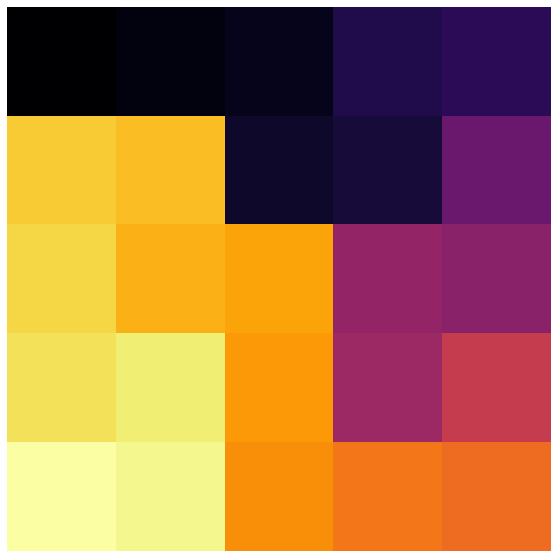

In [248]:
best = None
lengths = []
walks = []
for i in range(1000):
    G = simulate(5, 3, True)
#     if best:
#         print(best.max())
#     lengths.append(G.max())
    L = np.count_nonzero(G)
    lengths.append(L)
    walks.append(G)
#     if best is None or G.max() > best.max():
    if best is None or np.count_nonzero(G) >= np.count_nonzero(best):
        best = G

plt.figure(figsize=(10, 10))
plt.imshow(best, cmap='inferno')
plt.axis('off')

# decision trees? + parity
# random walks that close to a polygon
# (self-avoiding) random walks around obstructions
# add heuristics
# avoid and/or break at 
# add backtracking

(array([42.,  7.,  0., 52.,  0., 17., 60.,  0., 20.,  0., 70., 36.,  0.,
        80.,  0., 45., 84.,  0., 78.,  0., 85., 64.,  0., 96.,  0., 86.,
        51.,  0., 24.,  3.]),
 array([ 7. ,  7.6,  8.2,  8.8,  9.4, 10. , 10.6, 11.2, 11.8, 12.4, 13. ,
        13.6, 14.2, 14.8, 15.4, 16. , 16.6, 17.2, 17.8, 18.4, 19. , 19.6,
        20.2, 20.8, 21.4, 22. , 22.6, 23.2, 23.8, 24.4, 25. ]),
 <BarContainer object of 30 artists>)

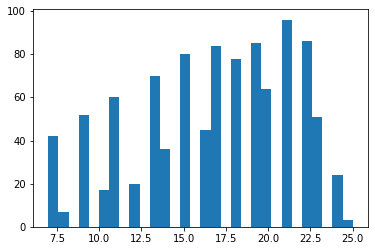

In [249]:
plt.hist(lengths, bins=30)

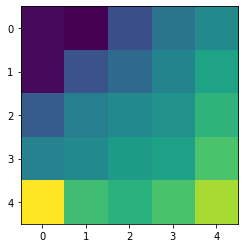

In [250]:
plt.imshow(np.average(np.stack(walks), axis=0))